<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_Perceiver_Experimental_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

# SAVE_PATH = "/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327_"
SAVE_PATH = "work/results/perceiver/210402"

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# ! pip install 'imgaug>=0.3.0'
# ! pip install einops

import sys
from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

170500096/170498071 [==============================] - 71s 0us/step
x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


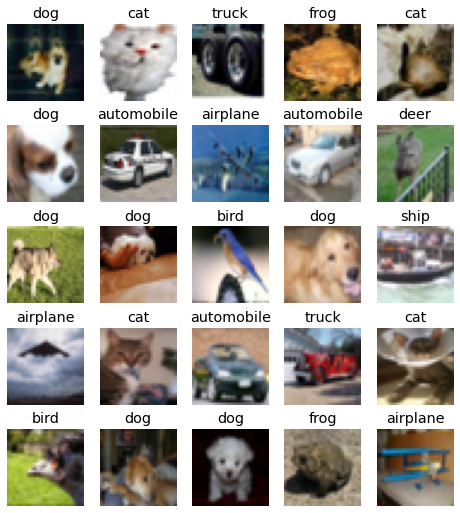

In [ ]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

Code based on [keras example](https://keras.io/examples/vision/randaugment/) .

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)
from imgaug import augmenters as iaa


def data_generator(split: str, 
                   batch_size: int,  
                   image_height: int, 
                   image_width: int,
                   shuffle_buffer: int = None, # 10000,
                   augmentation: str = None
                   ):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      image_height: Height of image.
      image_width: Width of image.
      shuffle_buffer: Number of elements used for shuffling.
      augmentation: Type of augmentation to use. ['simple_aug', 'rand_aug']

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  AUTO = tf.data.AUTOTUNE

  no_aug = tf.keras.Sequential(
    [
      Resizing(image_height, image_width, name='resize'),
      Rescaling(1./255., name='rescale')
    ]
  )

  simple_aug = tf.keras.Sequential(
    [
      Resizing(image_height, image_width, name='resize'),
      RandomFlip("horizontal", name='data_aug_hflip'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
      Rescaling(1./255., name='rescale')
    ]
  )

  rand_aug = iaa.RandAugment(n=3, m=7)

  def augment(images):
      # Input to `augment()` is a TensorFlow tensor which
      # is not supported by `imgaug`. This is why we first
      # convert it to its `numpy` variant.
      images = tf.cast(images, tf.uint8)
      return rand_aug(images=images.numpy())

  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(batch_size * 100 if shuffle_buffer is None else shuffle_buffer)
    ds = ds.batch(batch_size)

    if augmentation == 'simple_aug':
      ds = ds.map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
      
    elif augmentation == 'rand_aug':
      ds = ds.map(
        lambda x, y: (tf.image.resize(x, (image_height, image_width)), y),
        num_parallel_calls=AUTO,
      )
      ds = ds.map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO,
      )
      ds = ds.map(
        lambda x, y: (tf.math.divide(x, 255.0), y),
        num_parallel_calls=AUTO,
      )
      
    else:
      ds = ds.map(lambda x, y: (no_aug(x), y), num_parallel_calls=AUTO)

    ds = ds.prefetch(AUTO)

  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x, y: (no_aug(x), y), num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)

  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x, y: (no_aug(x), y), num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)

  else:
    raise ValueError(f"Unknown data split : {split}")

  return ds

# Model

##Perceiver

[Perceiver](https://arxiv.org/abs/2103.03206) from Jaegle et. al. .

The code is based on [perceiver_pytorch.py](https://github.com/lucidrains/perceiver-pytorch/blob/main/perceiver_pytorch/perceiver_pytorch.py) from [lucidrains/perceiver_pytorch](https://github.com/lucidrains/perceiver_pytorch) .  

**Good to know points from the paper**
*  Linear layers are implemented using Dense. In paper it is implied that 1x1 conv was used.
* 
* 




In [ ]:
from einops.layers.tensorflow import Rearrange
from einops import repeat
from datetime import datetime

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Add,
  AveragePooling1D,
  BatchNormalization, 
  Conv2D,
  Conv3D,
  Dense,
  Dropout,
  Embedding,
  Layer,
  LayerNormalization,
  MultiHeadAttention
)
from tensorflow import einsum, meshgrid

from functools import wraps
from math import pi


def cache_fn(func):
    cache = None
    @wraps(func)
    def cached_func(*args, _cache=False, **kwargs):
        if not _cache:
            return func(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = func(*args, **kwargs)
        return cache
    return cached_func


def fourier_encode(x: tf.Tensor, 
                   max_freq: float, 
                   num_bands: int = 4, 
                   base: float = 2.0) -> tf.Tensor:
  """Positional fourier encoding."""
  x = tf.expand_dims(x, -1)
  dtype, orig_x = x.dtype, x
  scales = tf.experimental.numpy.logspace(
    start=0., 
    stop=tf.math.log(max_freq / 2) / tf.math.log(base), 
    num=num_bands, 
    base = base, 
    dtype = dtype)
  scales = Rearrange('s -> () () () s')(scales)
  # x = [h,w,2,bands]
  x = x * scales * pi
  x = tf.concat([tf.math.sin(x), tf.math.cos(x), orig_x], axis=-1)
  return x


class InputByteArray(Layer):
  """Prepares input byte array for K, V."""

  def __init__(self,
               image_height: int = None, 
               image_width: int = None,
               batch_size: int = None, 
               max_freq: float = 224,
               num_freq_bands: int = 64,
               freq_base = 2.0,
               **kwargs):
    """Constructor"""
    super().__init__(**kwargs)
    self.max_freq = max_freq
    self.num_freq_bands = num_freq_bands
    self.freq_base = freq_base
    self.batch_size = batch_size
    self.image_height = image_height
    self.image_width = image_width

  @cache_fn
  def positional_encoding(self, x):
    x_shape = x.get_shape().as_list()
    assert len(x_shape) == 4, 'input data must have dim of 4'
    # 1. calculate fourier encoded positions in the range of [-1, 1]
    axis_pos = list(map(lambda num: tf.linspace(-1., 1., num), x_shape[1:3]))
    pos = tf.stack(meshgrid(*axis_pos), axis=-1)
    enc_pos = fourier_encode(pos, 
                             max_freq=self.max_freq, 
                             num_bands=self.num_freq_bands, 
                             base=self.freq_base)
    # 2. Merge the stacked dimension
    enc_pos = Rearrange('... n d -> ... (n d)')(enc_pos)
    # 3. Tile to the batch size
    # enc_pos = repeat(enc_pos, '... -> b ...', b=x_shape[0])
    enc_pos = tf.tile(tf.expand_dims(enc_pos, axis=0), 
                      [tf.shape(x)[0], 1, 1, 1], 
                      name='enc_pos')
    return enc_pos

  def call(self, x):
    # x_shape = x.get_shape().as_list()
    # assert len(x_shape) == 4, 'input data must have dim of 4'
    # # 1. calculate fourier encoded positions in the range of [-1, 1]
    # axis_pos = list(map(lambda num: tf.linspace(-1., 1., num), x_shape[1:3]))
    # pos = tf.stack(meshgrid(*axis_pos), axis=-1)
    # enc_pos = fourier_encode(pos, 
    #                          max_freq=self.max_freq, 
    #                          num_bands=self.num_freq_bands, 
    #                          base=self.freq_base)
    # # 2. Merge the stacked dimension
    # enc_pos = Rearrange('... n d -> ... (n d)')(enc_pos)
    # # 3. Tile to the batch size
    # # enc_pos = repeat(enc_pos, '... -> b ...', b=x_shape[0])
    # enc_pos = tf.tile(tf.expand_dims(enc_pos, axis=0), 
    #                   [tf.shape(x)[0], 1, 1, 1], 
    #                   name='enc_pos')
    # 4. concat to channels of data and flatten axis
    _cache = self.batch_size and self.image_height and self.image_width
    enc_pos = self.positional_encoding(x, _cache=_cache)
    x = tf.concat([x, enc_pos], axis=-1, name='data_input')
    x = Rearrange('b ... d -> b (...) d')(x)
    return x

  def get_config(self):
    return {'batch_size': self.batch_size,
            'image_height': self.image_height,
            'image_width': self.image_width,
            'max_freq': self.max_freq,
            'num_freq_bands': self.num_freq_bands,
            'freq_base': self.freq_base}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class InputLatentArray(Layer):
  """Prepares latent byte array for Q."""

  def __init__(self, num_latents: int = 1024, latent_dim: int = 512, **kwargs):
    """Constructor"""
    super().__init__(**kwargs)
    self.num_latents = num_latents
    self.latent_dim = latent_dim
    self.latents = self.add_weight('latent', 
                                   [self.num_latents, self.latent_dim],
                                   tf.float32,
                                   trainable=True)

  def call(self, x):
    x_shape = x.get_shape().as_list()
    assert len(x_shape) == 4, 'input data must have dim of 4'
    # z = repeat(self.latents, 'n d -> b n d', b=x_shape[0])
    z = tf.tile(tf.expand_dims(self.latents, axis=0), 
                [tf.shape(x)[0], 1, 1], 
                name='latent_input')
    return z

  def get_config(self):
    return {'num_latents': self.num_latents,
            'latent_dim': self.latent_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class GELU(Layer):
  """GELU with gated linear unit option."""

  def __init__(self, glu: bool = True, **kwargs):
    """Constructor"""
    super().__init__(**kwargs)
    self.glu = glu
    self.gelu = tf.keras.layers.Activation('gelu')

  def call(self, x):
    if self.glu:
      return self.gelu(x)
    else:
      x_input, x_gates = tf.split(x, 2, axis=-1)
      return x_input * self.gelu(x_gates)

  def get_config(self):
    return {'glu': self.glu}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self,
               latent_dims: list,
               geglu: bool = True, 
               dropout_rate: float = 0.25, 
               **kwargs):
    super().__init__(**kwargs)
    self.latent_dims = latent_dims
    self.geglu = geglu
    self.dropout_rate = dropout_rate
    self.lrn   = LayerNormalization(epsilon=1e-6, name='ln')
    self.dens1 = Dense(latent_dims[0], name='dens1', use_bias=False)
    self.gelu  = GELU(geglu, name=f'{"geglu" if geglu else "gelu"}')
    self.dens2 = Dense(latent_dims[1], name='dens2')
    self.drop  = Dropout(dropout_rate, name='drop')

  def call(self, x, training: bool = None):
    x = self.lrn(x)
    x = self.dens1(x)
    x = self.gelu(x)
    x = self.dens2(x)
    x = self.drop(x)
    return x
  
  def get_config(self):
    return {"latent_dims": self.latent_dims,
            "geglu": self.geglu,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


def mlp(latent_dims: list,
        geglu: bool = True, 
        dropout_rate: float = 0.25, 
        name: str = '') -> list:
  """Multilayer perceptron.
  
  Same as MLP(...). But this is not a layer, meaning that the layers listed 
  here will be shown separately in model.summary() .
  """
  assert len(latent_dims) == 2, "Length of `latent_dims` must be 2."
  layers = []  
  layers.append(LayerNormalization(epsilon=1e-6, name=f'{name}/ln{idx}'))
  layers.append(Dense(latent_dims[0], name=f'{name}/dens1'))
  layers.append(GELU(geglu, name=f'{name}/{"geglu" if geglu else "gelu"}'))
  layers.append(Dense(latent_dims[1], name=f'{name}/dens2'))
  layers.append(Dropout(dropout_rate, name=f'{name}/drop'))
  return layers


class Transformer(Layer):
  """Transformer module for cross attention or self attention.
  
  This is different than the `MultiHeadAttention` (MHA) layer. MHA shares the 
  same Q and K dimensions whereas this layer shares the K and V dimensions.
  """

  def __init__(self, 
               query_dim: int, 
               use_context: bool = False, 
               num_heads: int = 8, 
               dim_head: int = 64, 
               dropout: float = 0.25,
               **kwargs):
    """Constructor.

    Args:
      query_dim: Dimension of Query.
      use_context: Whether context (Key, Value) is used.
      num_heads: Number of heads.
      dim_head: Dimension per head.
      dropout: Dropout rate.
      
    """
    super().__init__(**kwargs)
    self.query_dim = query_dim
    self.num_heads = num_heads
    self.dim_head = dim_head
    self.dropout = dropout
    self.use_context = use_context

    self.lrn = LayerNormalization(epsilon=1e-6, name='ln')

    if self.use_context:
      self.lrn_ctxt = LayerNormalization(epsilon=1e-6, name='ln_ctxt')
    else:
      self.lrn_ctxt = None

    # Reference : VIT paper appendix.
    self.scale = dim_head ** -0.5

    inner_dim = self.dim_head * self.num_heads

    self.to_q = Dense(inner_dim, use_bias=False)
    self.to_k = Dense(inner_dim, use_bias=False)
    self.to_v = Dense(inner_dim, use_bias=False)

    self.dens  = Dense(self.query_dim, name='dens')
    # self.drop1 = Dropout(self.dropout, name='drop1')
    self.drop2 = Dropout(self.dropout, name='drop2')

  def call(self, x: tf.Tensor, context: tf.Tensor = None):
    """
    Args:
      x: Latent data.
      context: Input data.

    """
    x = self.lrn(x)
    q = self.to_q(x)

    if context is not None:
      assert self.lrn_ctxt, '`self.lrn_ctxt` is False.'
      context = self.lrn_ctxt(context)
      k = self.to_k(context)
      v = self.to_v(context)
    else:
      k = self.to_k(x)
      v = self.to_v(x)

    q = Rearrange('b n (h d) -> (b h) n d', h=self.num_heads)(q)
    k = Rearrange('b n (h d) -> (b h) n d', h=self.num_heads)(k)
    v = Rearrange('b n (h d) -> (b h) n d', h=self.num_heads)(v)

    sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
    attn = tf.math.softmax(sim, axis=-1)
    # attn = self.drop1(attn)

    x = einsum('b i j, b j d -> b i d', attn, v)
    x = Rearrange('(b h) n d -> b n (h d)', h=self.num_heads)(x)

    x = self.dens(x)
    x = self.drop2(x)

    return x

  def get_config(self):
    return {'query_dim'  : self.query_dim  ,
            'use_context': self.use_context,
            'num_heads'  : self.num_heads  ,
            'dim_head'   : self.dim_head   ,
            'dropout'    : self.dropout    }

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class Perceiver(Model):
  """Perceiver implementation. """
  
  def __init__(self,
               num_classes: int, 
               image_height: int, 
               image_width: int,
               batch_size: int = None,
               max_freq: float = 224,
               num_freq_bands: int = 64,
               freq_base: float = 2.0,
               num_latents: int = 1024,
               latent_dim: int = 512,
               latent_heads: int = 8,
               latent_head_dim: int = 512,
               cross_heads: int = 1,
               cross_head_dim: int = 512,
               attn_dropout: float = 0.2,
               mlp_dropout: float = 0.2,
               cross_depth: int = 8,
               latent_depth: int = 6,             
               weight_tie_layers: bool = False,
               preprocess: str = None,
               **kwargs):
    """Constructor.

    Args:
      num_classes: Number of classes.
      image_height: Height of image.
      image_width: Width of image.
      max_freq:
      num_freq_bands:
      freq_base:
      num_latents:
      latent_dim:
      latent_heads:
      latent_head_dim:
      cross_heads:
      cross_head_dim:
      attn_dropout:
      mlp_dropout:
      cross_depth:
      latent_depth:
      weight_tie_layers:
      preprocess: Whether to do preprocessing or not.
      
    """
    super().__init__(**kwargs)
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.batch_size = batch_size
    self.preprocess = preprocess

    # Position encoding
    self.max_freq = max_freq
    self.num_freq_bands = num_freq_bands
    self.freq_base = freq_base

    # Latent transformer
    self.num_latents = num_latents
    self.latent_dim = latent_dim
    self.latent_heads = latent_heads
    self.latent_head_dim = latent_head_dim

    # Cross attention
    self.cross_heads = cross_heads
    self.cross_head_dim = cross_head_dim

    self.attn_dropout = attn_dropout
    self.mlp_dropout = mlp_dropout

    # How many latent transformer repeats and how many input data attends.
    self.cross_depth = cross_depth
    self.latent_depth = latent_depth
    self.weight_tie_layers = weight_tie_layers

    # Model --------------------------------------------------------------------
    # data array for key and value.
    self.input_data = InputByteArray(batch_size=self.batch_size,
                                     image_height=self.image_height,
                                     image_width=self.image_width,
                                     max_freq=self.max_freq, 
                                     num_freq_bands=self.num_freq_bands, 
                                     freq_base=self.freq_base,
                                     name='input_data')
    
    # latent array for query.
    self.input_latent = InputLatentArray(num_latents=self.num_latents, 
                                         latent_dim=self.latent_dim, 
                                         name='input_latent')
    
    # context refers to the input data array.
    input_axis, input_channels = 2, 3
    # self.context_dim = input_axis * ((self.num_freq_bands * 2) + 1) + input_channels

    # cross attention module.
    cross_attn  = self.get_cross_attn()
    cross_mlp   = self.get_cross_mlp()

    # latent attention module. 
    # We do not want to share the weights within a module.
    latent_attn = [self.get_latent_attn() for _ in range(self.latent_depth)]
    latent_mlp  = [self.get_latent_mlp() for _ in range(self.latent_depth)]

    # stack modules to form Perceiver.
    self.blocks = []
    for i in range(self.cross_depth):
      cache_args = {'_cache': i > 0 and self.weight_tie_layers}
      cross_attn_i = cross_attn(cross_idx=i, **cache_args)
      cross_mlp_i  = cross_mlp(cross_idx=i)
      self.blocks.append((cross_attn_i, f'cross_attn_{i}'))
      self.blocks.append((cross_mlp_i,  f'cross_mlp_{i}' ))
      for j in range(self.latent_depth):
        latent_attn_j = latent_attn[j](cross_idx=i, latent_idx=j, **cache_args)
        latent_mlp_j  = latent_mlp[j](cross_idx=i, latent_idx=j)
        self.blocks.append((latent_attn_j, f'latent_attn_{i}_{j}'))
        self.blocks.append((latent_mlp_j,  f'latent_mlp_{i}_{j}'))

    self.avgpool = AveragePooling1D(pool_size=self.num_latents, name='avgpool')
    self.lrn = LayerNormalization(epsilon=1e-6, name='ln')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    
    z = self.input_latent(x)
    x = self.input_data(x)

    for l in self.blocks:
      if 'cross_attn' in l[1]:
        z = Add(name='skip_' + l[1])([l[0](z, context=x), z])
      else:
        z = Add(name='skip_' + l[1])([l[0](z), z])

    z = self.avgpool(z)
    # z = self.lrn(z)
    z = self.logits(z)

    return z
  
  def get_cross_attn(self):
    """Transformer of the cross attention module.
    Returns a function that can be cached, enabling weight sharing.
    """
    @cache_fn
    def cross_attn(cross_idx: int = 0):
      return Transformer(query_dim=self.latent_dim, 
                         use_context=True, 
                         num_heads=self.cross_heads, 
                         dim_head=self.cross_head_dim, 
                         dropout=self.attn_dropout, 
                         name=f'cross_attn_{cross_idx}')
    return cross_attn
    
  def get_cross_mlp(self):
    """MLP of the cross attention module. 
    Returns a function that can be cached, enabling weight sharing.    
    """
    @cache_fn
    def cross_mlp(cross_idx: int = 0):
      return MLP(latent_dims=[self.latent_dim, self.latent_dim],
                 geglu=True,
                 dropout_rate=self.mlp_dropout,
                 name=f'cross_mlp_{cross_idx}')
    return cross_mlp

  def get_latent_attn(self):
    """Transformer of the latent attention module.
    Returns a function that can be cached, enabling weight sharing.
    """
    @cache_fn
    def latent_attn(cross_idx: int = 0, latent_idx: int = 0):
      return Transformer(query_dim=self.latent_dim, 
                         use_context=False, 
                         num_heads=self.latent_heads, 
                         dim_head=self.latent_head_dim, 
                         dropout=self.attn_dropout, 
                         name=f'latent_attn_{cross_idx}_{latent_idx}')
    return latent_attn
  
  def get_latent_mlp(self):
    """MLP of the latent attention module. 
    Returns a function that can be cached, enabling weight sharing.    
    """
    @cache_fn      
    def latent_mlp(cross_idx: int = 0, latent_idx: int = 0):
      return MLP(latent_dims=[self.latent_dim, self.latent_dim],
                 geglu=True,
                 dropout_rate=self.mlp_dropout,
                 name=f'latent_mlp_{cross_idx}_{latent_idx}')
    return latent_mlp

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes"       : self.num_classes,
              "image_height"      : self.image_height,
              "image_width"       : self.image_width,
              "batch_size"        : self.batch_size,
              "max_freq"          : self.max_freq,
              "num_freq_bands"    : self.num_freq_bands,
              "freq_base"         : self.freq_base,
              "num_latents"       : self.num_latents,
              "latent_dim"        : self.latent_dim,
              "latent_heads"      : self.latent_heads,
              "latent_head_dim"   : self.latent_head_dim,
              "cross_heads"       : self.cross_heads,
              "cross_head_dim"    : self.cross_head_dim,
              "attn_dropout"      : self.attn_dropout,
              "mlp_dropout"       : self.mlp_dropout,
              "cross_depth"       : self.cross_depth,
              "latent_depth"      : self.latent_depth,
              "weight_tie_layers" : self.weight_tie_layers,
              "preprocess"        : self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

In [ ]:
model = Perceiver(num_classes=1000, 
                  image_height=224, 
                  image_width=224,
                  max_freq=224,
                  num_freq_bands=64,
                  freq_base=2.0,
                  num_latents=1024,
                  latent_dim=512,
                  latent_heads=8,
                  latent_head_dim=512//8,
                  cross_heads=1,
                  cross_head_dim=512,
                  attn_dropout=0.2,
                  mlp_dropout=0.2,
                  cross_depth=8,
                  latent_depth=6,             
                  weight_tie_layers=True,
                  preprocess=False).model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 1024, 512)    524288      input_1[0][0]                    
__________________________________________________________________________________________________
input_data (InputByteArray)     (None, 50176, 261)   0           input_1[0][0]                    
__________________________________________________________________________________________________
cross_attn_0 (Transformer)      (None, 1024, 512)    793610      input_latent[0][0]               
                                                                 input_data[0][0]             

# Train

Training configs.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
# shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

num_classes = 10 
image_height = 32
image_width = 32

# ['simple_aug', 'rand_aug']
augmentation = ''

Keras model.compile(...) and model.fit(...) .


In [ ]:
def train_and_eval(_model, checkpoint_dir=None, history_dir=None, verbose=1):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      checkpoint_dir: Path to save a checkpoint.
      history_dir: Path to save a history.
      verbose: Option for logging output during train and eval.

  Returns:
      A history instance that contains logged values per epoch.

  """
  steps_per_epoch = len(data_generator('train', 
                                       batch_size, image_height, image_width,
                                       augmentation=augmentation))

  _model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )

  if checkpoint_dir is not None:
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_dir,
      monitor="val_sparse_categorical_accuracy",
      save_best_only=True,
    )
    os.makedirs(os.path.join(checkpoint_dir, 'logs'), exist_ok = True)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=os.path.join(checkpoint_dir, 'logs'), 
      histogram_freq=epochs//10,
      update_freq=(steps_per_epoch // batch_size +
                   (steps_per_epoch % batch_size > 0)) * 5
    )
    callbacks=[tensorboard_callback, checkpoint_callback]
  else:
    callbacks = None

  start = time()
  history = _model.fit(
      data_generator('train', 
                     batch_size, image_height, image_width, 
                     augmentation=augmentation), 
      epochs=epochs, 
      steps_per_epoch=steps_per_epoch,
      validation_data=data_generator('val', 
                                     batch_size, image_height, image_width),
      callbacks=callbacks,
      verbose=verbose
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  
  if history_dir is not None:
    # Save history output, should be the same as the tensorboard logs.
    os.makedirs(os.path.join(history_dir), exist_ok = True) 
    np.save(os.path.join(history_dir, 'history.npy'), history.history)
  
  return history

# Loss and accuracy plots

In [ ]:
def plot(losses: list, 
         accuracies: list, 
         legend_labels: list, 
         subplot_title: list):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  
  for x, ll in zip(losses, legend_labels):
    c = ax1.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax1.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()   

  for x, ll in zip(accuracies, legend_labels):
    c = ax2.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax2.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()   

  plt.show()

#Experiments

In [ ]:
history = dict()

Check if the transformer dimension is causing overfitting.

In [ ]:
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [128]:
      for latent_dim in [128]:
        for latent_head_dim in [32,128]:
          for cross_head_dim in [32,128]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 128, 128)     16384       resize[0][0]                     
______________________________________________________________________________________________

Check if number of latents is causing the overfitting.

In [ ]:
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [32]:
      for latent_dim in [128]:
        for latent_head_dim in [128]:
          for cross_head_dim in [128]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 32, 128)      4096        resize[0][0]                     
______________________________________________________________________________________________

check if latent dim is causing overfitting

In [ ]:
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [128]:
      for latent_dim in [32]:
        for latent_head_dim in [128]:
          for cross_head_dim in [128]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 128, 32)      4096        resize[0][0]                     
______________________________________________________________________________________________

Check if number of bands affects the results.

In [ ]:
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [128]:
      for latent_dim in [128]:
        for latent_head_dim in [128]:
          for cross_head_dim in [128]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 128, 128)     16384       resize[0][0]                     
______________________________________________________________________________________________

Checking if smaller model is better.  
Previous experiments show that transformer dimension and number of latents doesnt affect much.

In [ ]:
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [32]:
      for latent_dim in [128]:
        for latent_head_dim in [32]:
          for cross_head_dim in [32]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=augmentation).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 32, 128)      4096        input_1[0][0]                    
__________________________________________________________________________________________________
input_data (InputByteArray)     (None, 1024, 69)     0           input_1[0][0]                    
__________________________________________________________________________________________________
cross_attn_0 (Transformer)      (None, 32, 128)      13130       input_latent[0][0]               
                                                                 input_data[0][0]             

In [ ]:
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [16]:
      for latent_dim in [128]:
        for latent_head_dim in [16]:
          for cross_head_dim in [16]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=augmentation).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 128)      2048        input_1[0][0]                    
__________________________________________________________________________________________________
input_data (InputByteArray)     (None, 1024, 69)     0           input_1[0][0]                    
__________________________________________________________________________________________________
cross_attn_0 (Transformer)      (None, 16, 128)      6826        input_latent[0][0]               
                                                                 input_data[0][0]             

Check if randaug is different.

In [ ]:
augmentation = 'rand_aug'
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [32]:
      for latent_dim in [128]:
        for latent_head_dim in [32]:
          for cross_head_dim in [32]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=augmentation).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 32, 128)      4096        input_1[0][0]                    
__________________________________________________________________________________________________
input_data (InputByteArray)     (None, 1024, 69)     0           input_1[0][0]                    
__________________________________________________________________________________________________
cross_attn_0 (Transformer)      (None, 32, 128)      13130       input_latent[0][0]               
                                                                 input_data[0][0]             

Check if longer training will help. Overfitting.

In [ ]:
augmentation = ''
epochs = 500
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [16]:
      for latent_dim in [128]:
        for latent_head_dim in [16]:
          for cross_head_dim in [16]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=augmentation).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 128)      2048        input_1[0][0]                    
__________________________________________________________________________________________________
input_data (InputByteArray)     (None, 1024, 69)     0           input_1[0][0]                    
__________________________________________________________________________________________________
cross_attn_0 (Transformer)      (None, 16, 128)      6826        input_latent[0][0]               
                                                                 input_data[0][0]             

KeyboardInterrupt: ignored

Check if even smaller dimension=8 will help. No difference compared to dim 16.

In [ ]:
augmentation = ''
epochs = 100
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [8]:
      for latent_dim in [128]:
        for latent_head_dim in [8]:
          for cross_head_dim in [8]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=augmentation).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=2
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 8, 128)       1024        input_1[0][0]                    
__________________________________________________________________________________________________
input_data (InputByteArray)     (None, 1024, 69)     0           input_1[0][0]                    
__________________________________________________________________________________________________
cross_attn_0 (Transformer)      (None, 8, 128)       3674        input_latent[0][0]               
                                                                 input_data[0][0]             

Rand augmentation + longer training helps. But still stuck at 65%.

In [ ]:
augmentation = 'rand_aug'
epochs = 500
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [16]:
      for latent_dim in [128]:
        for latent_head_dim in [16]:
          for cross_head_dim in [16]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=augmentation).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld' \
                                          f'_{augmentation}', 
                  verbose=2
                )
                tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 128)      2048        input_1[0][0]                    
__________________________________________________________________________________________________
input_data (InputByteArray)     (None, 1024, 69)     0           input_1[0][0]                    
__________________________________________________________________________________________________
cross_attn_0 (Transformer)      (None, 16, 128)      6826        input_latent[0][0]               
                                                                 input_data[0][0]             

In [ ]:
augmentation = 'rand_aug'
epochs = 300
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [8]:
      for latent_dim in [128]:
        for latent_head_dim in [8]:
          for cross_head_dim in [8]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                tf.keras.backend.clear_session()
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=augmentation).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld' \
                                          f'_{augmentation}', 
                  verbose=2
                )
                tf.keras.backend.clear_session()